## 드라이브마운트 및 변수초기화

In [ ]:
# 메모리 변수 모두 제거
all = [var for var in globals() if var[0] != '_']
for var in all:
    del globals()[var]

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 2. yolo 설치

In [ ]:
!git clone https://github.com/ultralytics/yolov5
%cd yolov5
!pip install -qr requirements.txt

Cloning into 'yolov5'...
remote: Enumerating objects: 10147, done.
remote: Counting objects: 100% (93/93), done.
remote: Compressing objects: 100% (51/51), done.
remote: Total 10147 (delta 50), reused 77 (delta 42), pack-reused 10054
Receiving objects: 100% (10147/10147), 10.38 MiB | 19.75 MiB/s, done.
Resolving deltas: 100% (7029/7029), done.
/content/yolov5/yolov5


## 폴더 복사 이미지 리스트만들기
- 폴더 복사 안하고 만드는법 찾아야함

In [ ]:
import os
os.mkdir('/content/dataset')
os.mkdir('/content/dataset/export')

In [ ]:
#shutil.rmtree('/content/dataset/export/labels') ## 폴더삭제

In [ ]:
import shutil

shutil.copytree("/content/drive/MyDrive/4조/데이터셋/kfood2/만두/만두", "/content/dataset/export/images") #폴더 복사

'/content/dataset/export/images'

In [ ]:
from glob import glob
file_path = '/content/dataset/export/images'

img_list=glob(file_path+'/*.jpg')
print(len(img_list))

1000


In [ ]:
os.mkdir('/content/dataset/export/labels') #라벨 폴더 만들기

### 이미지 crop_area 가지고 오기

In [ ]:
with open("/content/dataset/export/images/crop_area.properties", "r") as f: #복사한 폴더에 crop_area 읽어오기
    x = f.readlines()
print(x[0])

Img_049_0000=111,26,432,311



In [ ]:
x[0]
img_dic = dict()
for line in x: #한 줄씩읽어서 dic 형태로 만들었다
  name = line.split('=')[0]
  value = line.split('=')[1].split('\n')[0].split(',')
  value = list(map(int, value))
  img_dic[name] = value

In [ ]:
img_dic[img_list[2].split('/')[-1].split('.')[0]] # x, y x`, y`

[0, 1, 476, 341]

In [ ]:
img_list[2]

'/content/dataset/export/images/Img_049_0222.jpg'

In [ ]:
import PIL.Image as Image

image1 = Image.open(img_list[0]).size
image1

(527, 400)

0.3728932584269663 0.38375 0.021067415730337078 0.2375
/content/dataset/export/images/Img_049_0380.jpg


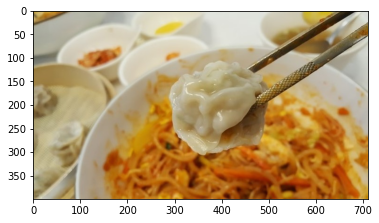

In [ ]:
## x,y 좌표 정규화 하기전

import cv2
import matplotlib.pyplot as plt
a = img_list[15]
img = cv2.imread(a)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # OpenCV는 기본적으로 BGR 형식을 따르므로, RGB 형식으로 변경

image_width, image_height = Image.open(a).size[0], Image.open(a).size[1]
xy =img_dic[a.split('/')[-1].split('.')[0]] # x, y x`, y`

# 왼쪽 위 좌표와 오른쪽 아래 좌표
x1, y1 = xy[0], xy[1]
x2, y2 = xy[2], xy[3]
print(x1, y1, x2, y2)
print(a)
c = (0, 255, 0) # mask인 경우 초록색
# 사각형 그리기
cv2.rectangle(
    img,
    (int(x1), int(y1)), # 왼쪽 위 좌표
    (int(x2), int(y2)), # 오른쪽 아래 좌표
    color=c, # 색상
    thickness=2, # 굵기
)

        # 텍스트 그리기

plt.imshow(img)
plt.show()

## x,y좌표 정규화 및 label 저장
- yolo의경우 x 평균값, y 평균값, with, height
- 0~1의 값으로 표현하여야한다

In [ ]:
from PIL import Image

for name in img_list:
  f_name = name.split('/')[-1].split('.')[0]
  with open('/content/dataset/export/labels/'+f_name+'.txt','w') as f:

    if f_name in img_dic: # crop_area가 정해져 있는경우
      image_size = Image.open(name).size
      xy = img_dic[f_name]

      xy[0], xy[2] = ((xy[0]+xy[2])/2)/image_size[0], abs((xy[2]-xy[0])/image_size[0]) #순서가 바뀌는 경우 절대값
      xy[1], xy[3] = ((xy[1]+xy[3])/2)/image_size[1], abs((xy[3]-xy[1])/image_size[1])
      
      f.write(f'0 {xy[0]} {xy[1]} {xy[2]} {xy[3]}')
    else:
      f.write('0 0.5 0.5 1.0 1.0') #crop_area가 정해져 있지 않은경우

In [ ]:
img_list[0].split('/')[-1].split('.')[0]

'Img_049_0487'

/content/dataset/export/images/Img_049_0565.jpg
클래스: 0, 중심 좌표: (0.39944, 0.50000), 너비: 0.67792, 높이: 1.00000


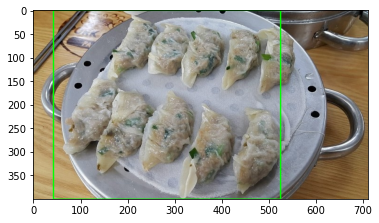

In [ ]:
import PIL.Image as Image
import cv2
import matplotlib.pyplot as plt

a = img_list[25]
print(a)
img = cv2.imread(a)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # OpenCV는 기본적으로 BGR 형식을 따르므로, RGB 형식으로 변경

label_name = a.split('/')[-1].split('.')[0]

with open('/content/dataset/export/labels/'+label_name+'.txt') as f:
    # 각 객체(object)의 바운딩 박스 정보를 하나씩 확인하며
    for instance in f.readlines():
        image_width, image_height = Image.open(a).size[0], Image.open(a).size[1]

        label, x, y, width, height = map(float, instance.strip().split())
        print(f'클래스: {int(label)}, 중심 좌표: ({x:.5f}, {y:.5f}), 너비: {width:.5f}, 높이: {height:.5f}')

        if int(label) == 0:
            c = (0, 255, 0) # mask인 경우 초록색
        elif int(label) == 1:
            c = (255, 0, 0) # no-mask인 경우 빨간색
        
        # 왼쪽 위 좌표와 오른쪽 아래 좌표
        x1, y1 = image_width * (x - width / 2), image_height * (y - height / 2)
        x2, y2 = image_width * (x + width / 2), image_height * (y + height / 2)
        

        # 사각형 그리기
        cv2.rectangle(
            img,
            (int(x1), int(y1)), # 왼쪽 위 좌표
            (int(x2), int(y2)), # 오른쪽 아래 좌표
            color=c, # 색상
            thickness=2, # 굵기
        )

        # 텍스트 그리기

plt.imshow(img)
plt.show()

## train, test split
- 파일의 경로를 txt 파일로 만들어 나누었다

In [ ]:
from sklearn.model_selection import train_test_split
 
train_img_list,val_img_list = train_test_split(img_list,test_size=0.2,random_state=2000)
print(len(train_img_list),len(val_img_list))
 
#나눈 데이터의 경로를 train.txt 와 val.txt에 각각 쓰기
with open('/content/dataset/train.txt','w') as f:
    f.write('\n'.join(train_img_list)+'\n')
 
with open('/content/dataset/val.txt','w') as f:
    f.write('\n'.join(val_img_list)+'\n')

800 200


## yaml 생성

In [ ]:
import yaml
 
#yaml파일 불러오기
with open('/content/dataset/data.yaml') as f:
  data = yaml.safe_load(f) # 꼭 safe_load 할것 업데이트 되면서 그냥 load에는 파람 필요함

In [ ]:
print(data)
 
#데이터 수정
data['train']='/content/dataset/train.txt'
data['val']='/content/dataset/val.txt'
data['nc']=1
data['names']=['mando']
 
#yaml파일 저장
with open('/content/dataset/data.yaml','w') as f:
    yaml.dump(data,f)
 
print(data)

{'names': ['mando'], 'nc': 1, 'train': '/content/dataset/train.txt', 'val': '/content/dataset/val.txt'}
{'names': ['mando'], 'nc': 1, 'train': '/content/dataset/train.txt', 'val': '/content/dataset/val.txt'}


In [ ]:
!python train.py --img 416 --batch 4 --epochs 30 --data /content/dataset/data.yaml --cfg ./models/yolov5s.yaml --weights yolov5s.pt --name man_results

train: weights=yolov5s.pt, cfg=./models/yolov5s.yaml, data=/content/dataset/data.yaml, hyp=data/hyps/hyp.scratch.yaml, epochs=30, batch_size=4, imgsz=416, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, adam=False, sync_bn=False, workers=8, project=runs/train, name=man_results, exist_ok=False, quad=False, linear_lr=False, label_smoothing=0.0, patience=100, freeze=0, save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v6.0-76-g79bca2b torch 1.9.0+cu111 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

hyperparameters: lr0=0.01, lrf=0.1, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015, hsv_s=0.7, hs

In [ ]:
%load_ext tensorboard
%tensorboard --logdir /content/yolov5/runs/

In [ ]:
from IPython.display import Image
import os

#val_img_path = val_img_list[12]
val_img_path = '/content/mando_test4.jpg'

!python detect.py --weights /content/yolov5/yolov5/runs/train/man_results/weights/best.pt --img 416 --conf 0.1 --source "{val_img_path}"

detect: weights=['/content/yolov5/yolov5/runs/train/man_results/weights/best.pt'], source=/content/mando_test4.jpg, imgsz=[416, 416], conf_thres=0.1, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.0-76-g79bca2b torch 1.9.0+cu111 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

Fusing layers... 
Model Summary: 213 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
image 1/1 /content/mando_test4.jpg: 416x416 1 mando, Done. (0.006s)
Speed: 0.4ms pre-process, 6.5ms inference, 1.6ms NMS per image at shape (1, 3, 416, 416)
Results saved to runs/detect/exp7


In [ ]:
!pip3 install labelImg

In [ ]:
!labelImg

qt.qpa.xcb: could not connect to display 
qt.qpa.plugin: Could not load the Qt platform plugin "xcb" in "" even though it was found.
This application failed to start because no Qt platform plugin could be initialized. Reinstalling the application may fix this problem.

Available platform plugins are: eglfs, linuxfb, minimal, minimalegl, offscreen, vnc, wayland-egl, wayland, wayland-xcomposite-egl, wayland-xcomposite-glx, webgl, xcb.

